## Import libs

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.data import Dataset
from tensorflow.keras.optimizers import Adam


from benchmark.models.madras_laftr.models import *
from benchmark.models.madras_laftr.learning import *
from benchmark.util.load_data import load_data
from benchmark.util.evaluation import *

## Preliminaries

In [2]:
batch_size = 64
epochs = 10
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate)
CLAS_COEFF = 1.
FAIR_COEFF = 1.
RECON_COEFF = 0.
hidden_layer_specs = {'clas':[8] , 'enc':[8] , 'dec':[8] , 'adv':[8]}

## Load data

In [3]:
data_name = 'adult-race'

In [4]:
x_train, y_train, a_train = load_data(data_name, 'train')
raw_data = (x_train, y_train, a_train)

In [5]:
xdim = x_train.shape[1]
ydim = y_train.shape[1]
adim = a_train.shape[1]
zdim = 8

In [6]:
train_data = Dataset.from_tensor_slices((x_train, y_train, a_train))
train_data = train_data.batch(batch_size, drop_remainder=True)
train_data


<BatchDataset shapes: ((64, 112), (64, 1), (64, 5)), types: (tf.float64, tf.float64, tf.float64)>

In [7]:
x_valid, y_valid, a_valid = load_data(data_name, 'valid')

valid_data = Dataset.from_tensor_slices((x_valid, y_valid, a_valid))
valid_data = valid_data.batch(batch_size, drop_remainder=True)

In [8]:
x_test, y_test, a_test = load_data(data_name, 'test')

test_data = Dataset.from_tensor_slices((x_test, y_test, a_test))
test_data = test_data.batch(batch_size, drop_remainder=True)

## Testing if models are being trained

### For DP

In [9]:
model = DemParGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, clas_coeff=CLAS_COEFF, fair_coeff=FAIR_COEFF)

In [10]:
ret = train_loop(model, raw_data, train_data, 1, opt)

> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc
> 1 | -0.0017665326595306396 | 0.5028232932090759 | 0.5081229209899902 | 0.9201741218566895 | 0.6347811671087533 | 0.5554265136230213 | -101.54302055702918


In [11]:
Y, A, Y_hat, A_hat = fair_evaluation(model, valid_data)
ret = compute_metrics(Y, A, Y_hat, A_hat, adim)

> Class Acc | Adv Acc
> 0.8228058510638298 | 0.7191397078493809
> DP | DEqOdds | DEqOpp
> 0.542546845972538 | 0.8242955364403315 | 0.6710115447640419
> Confusion Matrix 
TN: 4239.0 | FP: 319.0 
FN: 747.0 | TP: 711.0


### For EqOdds

In [12]:
model = EqOddsUnweightedGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, clas_coeff=CLAS_COEFF, fair_coeff=FAIR_COEFF)

In [13]:
ret = train_loop(model, raw_data, train_data, 1, opt)

> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc
> 1 | 0.0054025352001190186 | 0.4891658425331116 | 0.4729582369327545 | 0.9201741218566895 | 0.7149370026525199 | 0.6596622554590278 | -101.54302055702918


In [14]:
Y, A, Y_hat, A_hat = fair_evaluation(model, valid_data)
ret = compute_metrics(Y, A, Y_hat, A_hat, adim)

> Class Acc | Adv Acc
> 0.8356050531914894 | 0.7191397078493809
> DP | DEqOdds | DEqOpp
> 0.4168192371726036 | 0.8621016931720078 | 0.8281693235039711
> Confusion Matrix 
TN: 4241.0 | FP: 317.0 
FN: 672.0 | TP: 786.0


### For EqOpp

In [15]:
model = EqOppUnweightedGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, clas_coeff=CLAS_COEFF, fair_coeff=FAIR_COEFF)

In [16]:
ret = train_loop(model, raw_data, train_data, 1, opt)

> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc
> 1 | 0.002235572785139084 | 0.4801531732082367 | 0.47465020418167114 | 0.9201741218566895 | 0.73532824933687 | 0.6643870568362408 | -101.54302055702918


In [17]:
Y, A, Y_hat, A_hat = fair_evaluation(model, valid_data)
ret = compute_metrics(Y, A, Y_hat, A_hat, adim)

> Class Acc | Adv Acc
> 0.8375997340425532 | 0.7191397078493809
> DP | DEqOdds | DEqOpp
> 0.37143559753894806 | 0.8474010382778943 | 0.7953730709850788
> Confusion Matrix 
TN: 4212.0 | FP: 346.0 
FN: 631.0 | TP: 827.0


## Models

In [18]:
cmap = sns.light_palette("seagreen", as_cmap=True)

In [19]:
#For DP
model = DemParGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, clas_coeff=CLAS_COEFF, fair_coeff=FAIR_COEFF)
ret = train_loop(model, raw_data, train_data, epochs, opt)
Y, A, Y_hat, A_hat = fair_evaluation(model, valid_data)
ret4dp = compute_metrics(Y, A, Y_hat, A_hat, adim)

> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc
> 1 | 0.006861785892397165 | 0.49368488788604736 | 0.4730995297431946 | 0.9201741218566895 | 0.7424568965517241 | 0.6684072826166368 | -101.54302055702918
> 2 | 0.008602410554885864 | 0.4952690899372101 | 0.4694618582725525 | 0.9201741218566895 | 0.8358338859416445 | 0.7178519111848004 | -101.54302055702918
> 3 | 0.010768413543701172 | 0.5016729831695557 | 0.46936774253845215 | 0.9201741218566895 | 0.839481100795756 | 0.7178519111848004 | -101.54302055702918
> 4 | 0.012761235237121582 | 0.5079113841056824 | 0.4696276783943176 | 0.9201741218566895 | 0.8406415782493368 | 0.7178519111848004 | -101.54302055702918
> 5 | 0.013243247754871845 | 0.5096162557601929 | 0.46988651156425476 | 0.9201741218566895 | 0.8417606100795756 | 0.7178519111848004 | -101.54302055702918
> 6 | 0.013512630946934223 | 0.5106725692749023 | 0.4701346755027771 | 0.9201741218566895 | 0.8431283156498673 | 0.7178519111848004 | -101.5

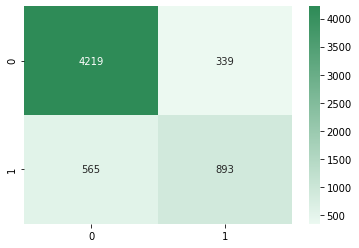

In [20]:
sns.heatmap(ret4dp[4], cmap=cmap, annot=True, fmt='g')

In [21]:
#For EQODDS
model = EqOddsUnweightedGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, clas_coeff=CLAS_COEFF, fair_coeff=FAIR_COEFF)
ret = train_loop(model, raw_data, train_data, epochs, opt)
Y, A, Y_hat, A_hat = fair_evaluation(model, valid_data)
ret4eqodds = compute_metrics(Y, A, Y_hat, A_hat, adim)

> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc
> 1 | 0.007155259605497122 | 0.4908435344696045 | 0.4693777561187744 | 0.9201741218566895 | 0.7508289124668435 | 0.6743754523383844 | -101.54302055702918
> 2 | 0.009872376918792725 | 0.49795088171958923 | 0.46833375096321106 | 0.9201741218566895 | 0.8361240053050398 | 0.7178519111848004 | -101.54302055702918
> 3 | 0.011024693958461285 | 0.5022695660591125 | 0.46919548511505127 | 0.9201741218566895 | 0.8397712201591512 | 0.7178519111848004 | -101.54302055702918
> 4 | 0.011711816303431988 | 0.5047871470451355 | 0.4696516990661621 | 0.9201741218566895 | 0.8411803713527851 | 0.7178519111848004 | -101.54302055702918
> 5 | 0.012893577106297016 | 0.5085545778274536 | 0.46987384557724 | 0.9201741218566895 | 0.8422579575596817 | 0.7178519111848004 | -101.54302055702918
> 6 | 0.013506968505680561 | 0.5105048418045044 | 0.46998393535614014 | 0.9201741218566895 | 0.8435842175066313 | 0.7178519111848004 | -101.5

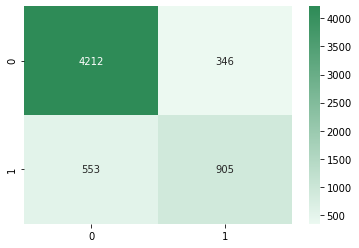

In [22]:
sns.heatmap(ret4eqodds[4], cmap=cmap, annot=True, fmt='g')

In [23]:
#For EQOPP
model = EqOddsUnweightedGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, clas_coeff=CLAS_COEFF, fair_coeff=FAIR_COEFF)
ret = train_loop(model, raw_data, train_data, epochs, opt)
Y, A, Y_hat, A_hat = fair_evaluation(model, valid_data)
ret4eqopp = compute_metrics(Y, A, Y_hat, A_hat, adim)

> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc
> 1 | 0.007153590675443411 | 0.49083685874938965 | 0.4693760871887207 | 0.9201741218566895 | 0.7508703580901857 | 0.6743754523383844 | -101.54302055702918
> 2 | 0.009862571954727173 | 0.49791088700294495 | 0.4683231711387634 | 0.9201741218566895 | 0.8360411140583555 | 0.7178519111848004 | -101.54302055702918
> 3 | 0.010871042497456074 | 0.501814603805542 | 0.4692014455795288 | 0.9201741218566895 | 0.8400613395225465 | 0.7178519111848004 | -101.54302055702918
> 4 | 0.01133252214640379 | 0.5036506056785583 | 0.46965304017066956 | 0.9201741218566895 | 0.8410560344827587 | 0.7178519111848004 | -101.54302055702918
> 5 | 0.012838025577366352 | 0.5083882808685303 | 0.46987420320510864 | 0.9201741218566895 | 0.842092175066313 | 0.7178519111848004 | -101.54302055702918
> 6 | 0.013357222080230713 | 0.5100574493408203 | 0.4699857831001282 | 0.9201741218566895 | 0.8436256631299734 | 0.7178519111848004 | -101.54

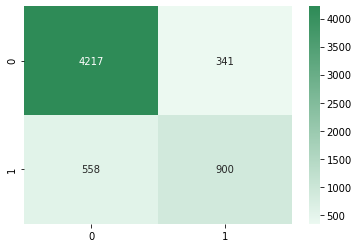

In [24]:
sns.heatmap(ret4eqopp[4], cmap=cmap, annot=True, fmt='g')

In [25]:
sns.set_style('darkgrid')

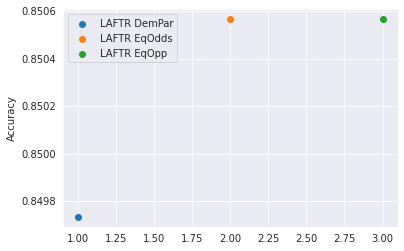

In [26]:
'''plt.plot()
plt.ylabel('Accuracy')

# plotting the line 1 points 
# plt.plot(fair_coeff_list, laftr_accs, label = "laftr")
# line 2 points

# plotting the line 2 points 
plt.plot(fair_coeff_list, unfair_accs4dp, label = "LAFTR DP")
plt.plot(fair_coeff_list, unfair_accs4di, '--', label = "LAFTR EODD")
plt.plot(fair_coeff_list, unfair_accs4deopp, ':', label = "LAFTR EOPP")
plt.xlabel('Fair coefficient')
plt.legend()
plt.show()'''

y=[2,4,6]
sns.set_style('darkgrid')
plt.ylabel('Accuracy')

plt.scatter(1, ret4dp[0], label = "LAFTR DemPar")

plt.scatter(2, ret4eqodds[0], label = "LAFTR EqOdds")

plt.scatter(3, ret4eqopp[0], label = "LAFTR EqOpp")

#plt.xlabel('Fair coefficient')
plt.legend()

plt.show()

In [27]:
'''plt.plot()
plt.ylabel('\u0394DP')

# plotting the line 1 points 
#plt.plot(fair_coeff_list, laftr_dps, label = "laftr")
# line 2 points

# plotting the line 2 points 
plt.plot(fair_coeff_list, unfair_dps4dp, label = "LAFTR DP")
plt.plot(fair_coeff_list, unfair_dps4di, '--', label = "LAFTR EODD")
plt.plot(fair_coeff_list, unfair_dps4deopp, ':', label = "LAFTR EOPP")

plt.xlabel('Fair coefficient')
plt.legend()
plt.show()'''

'plt.plot()\nplt.ylabel(\'ΔDP\')\n\n# plotting the line 1 points \n#plt.plot(fair_coeff_list, laftr_dps, label = "laftr")\n# line 2 points\n\n# plotting the line 2 points \nplt.plot(fair_coeff_list, unfair_dps4dp, label = "LAFTR DP")\nplt.plot(fair_coeff_list, unfair_dps4di, \'--\', label = "LAFTR EODD")\nplt.plot(fair_coeff_list, unfair_dps4deopp, \':\', label = "LAFTR EOPP")\n\nplt.xlabel(\'Fair coefficient\')\nplt.legend()\nplt.show()'

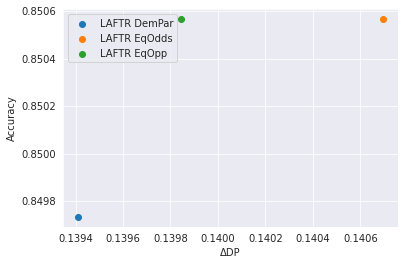

In [28]:
'''plt.plot()
plt.ylabel('Accuracy')

# plotting the line 1 points 
# plt.plot(laftr_dps, laftr_accs, label = "laftr")
# line 2 points

# plotting the line 2 points 
plt.plot(sorted_unfair_dps4dp, sorted_unfair_accs_dps4dp, label = "LAFTR DP")
plt.plot(sorted_unfair_dps4di, sorted_unfair_accs_dps4di, '--', label = "LAFTR EODD")
plt.plot(sorted_unfair_dps4deopp, sorted_unfair_accs_dps4deopp, '--', label = "LAFTR EOPP")

plt.xlabel('\u0394DP')
plt.legend()
plt.show()'''

plt.plot()
plt.ylabel('Accuracy')

plt.scatter(ret4dp[1], ret4dp[0], label = "LAFTR DemPar")

plt.scatter(ret4eqodds[1], ret4eqodds[0], label = "LAFTR EqOdds")

plt.scatter(ret4eqopp[1], ret4eqopp[0], label = "LAFTR EqOpp")

plt.xlabel('\u0394DP')
plt.legend()
plt.show()

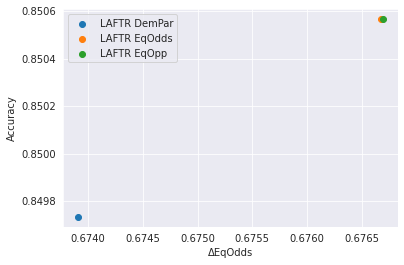

In [29]:
'''plt.plot()
plt.ylabel('Accuracy')

# plotting the line 1 points 
# plt.plot(laftr_dps, laftr_accs, label = "laftr")
# line 2 points

# plotting the line 2 points 
plt.plot(sorted_unfair_dis4dp, sorted_unfair_accs_dis4dp, '--', label = "LAFTR DP")
plt.plot(sorted_unfair_dis4di, sorted_unfair_accs_dis4di, label = "LAFTR EODD")
plt.plot(sorted_unfair_dis4deopp, sorted_unfair_accs_dis4deopp, '--', label = "LAFTR EOPP")

plt.xlabel('\u0394EOdds')
plt.legend()
plt.show()'''

plt.plot()
plt.ylabel('Accuracy')

plt.scatter(ret4dp[2], ret4dp[0], label = "LAFTR DemPar")

plt.scatter(ret4eqodds[2], ret4eqodds[0], label = "LAFTR EqOdds")

plt.scatter(ret4eqopp[2], ret4eqopp[0], label = "LAFTR EqOpp")

plt.xlabel('\u0394EqOdds')
plt.legend()
plt.show()

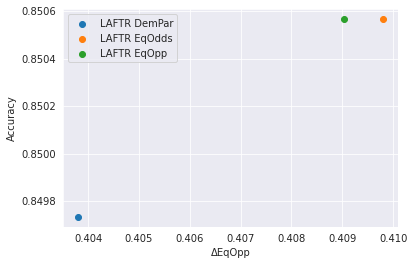

In [30]:
'''plt.plot()
plt.ylabel('Accuracy')

# plotting the line 1 points 
plt.plot(laftr_dps, laftr_accs, label = "laftr")
# line 2 points#

# plotting the line 2 points 
plt.plot(sorted_unfair_deopps4dp, sorted_unfair_accs_eopps4dp, '--', label = "LAFTR DP")
plt.plot(sorted_unfair_deopps4di, sorted_unfair_accs_eopps4di, '--', label = "LAFTR EODD")
plt.plot(sorted_unfair_deopps4deopp, sorted_unfair_accs_eopps4deopp, label = "LAFTR EOPP")

plt.xlabel('\u0394EOpp')
plt.legend()
plt.show()'''

plt.plot()
plt.ylabel('Accuracy')

plt.scatter(ret4dp[3], ret4dp[0], label = "LAFTR DemPar")

plt.scatter(ret4eqodds[3], ret4eqodds[0], label = "LAFTR EqOdds")

plt.scatter(ret4eqopp[3], ret4eqopp[0], label = "LAFTR EqOpp")

plt.xlabel('\u0394EqOpp')
plt.legend()
plt.show()